In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import glob
import re
%matplotlib inline

In [2]:
def getTopN(n, filename, keys=['pocket','rec','lig'], redkeys=['rec','lig'], nred=None):
    smina=pd.read_csv(filename)
    
    if nred:
        smina=smina.sample(frac=1).groupby('pocket').head(nred)
    
    smina_g=smina.groupby(keys)

    smina['good2']=(smina['rmsd']<2)
    smina['good1']=(smina['rmsd']<1)
    smina['good3']=(smina['rmsd']<3)

    smina_top=pd.DataFrame(index=range(1,n+1),columns=['good1','good2','good3'])
    smina_last=smina_g.nth(0)[['rmsd','good1','good2','good3']]

    smina_top.loc[1]=[smina_last['good1'].mean(), smina_last['good2'].mean(), smina_last['good3'].mean()]

    idx=smina_g.nth(0).index

    base=pd.DataFrame(None,index=idx,columns=['rmsd','good2','good1','good3'])

    for i in range(1,n):
        gcur_row=base.combine_first(smina_g.nth(i)[['rmsd','good1','good2','good3']]).fillna(False)
        smina_last+=gcur_row
        smina_top.loc[i+1]=[smina_last['good1'].mean(), smina_last['good2'].mean(), smina_last['good3'].mean()]
    
    return smina_top

In [147]:
smina_top=getTopN(9, 'sminadocked_rmsds.csv')

In [148]:
gnina_top=getTopN(9, 'gninadocked_rmsds.csv')

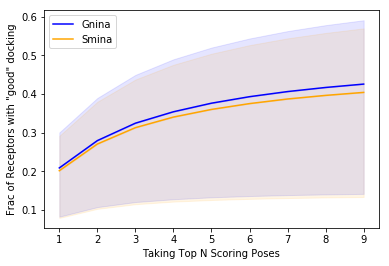

In [153]:
plt.plot([1,2,3,4,5,6,7,8,9],gnina_top['good2'],label='Gnina',color='blue')
plt.plot([1,2,3,4,5,6,7,8,9],smina_top['good2'],label='Smina',color='orange')
plt.fill_between([1,2,3,4,5,6,7,8,9],gnina_top['good2'].astype('float64').values,gnina_top['good1'].astype('float64').values,alpha=0.1,color='blue')
plt.fill_between([1,2,3,4,5,6,7,8,9],gnina_top['good2'].astype('float64').values,gnina_top['good3'].astype('float64').values,alpha=0.1,color='blue')
plt.fill_between([1,2,3,4,5,6,7,8,9],smina_top['good2'].astype('float64').values,smina_top['good1'].astype('float64').values,alpha=0.1,color='orange')
plt.fill_between([1,2,3,4,5,6,7,8,9],smina_top['good2'].astype('float64').values,smina_top['good3'].astype('float64').values,alpha=0.1,color='orange')
plt.legend(loc='upper left')
plt.xlabel('Taking Top N Scoring Poses')
#plt.ylim(0.4,1)
plt.ylabel('Frac of Receptors with "good" docking')
plt.savefig('PercentGood_smgn_CD.png', dpi=1000)

In [311]:
def select_randkeys(dic, nred):
    sel_keys=set()

    for pocket, data in dic.items():
        keys=data.keys()
        if len(keys)<nred:
            use=len(keys)
        else:
            use=nred
        random.seed(42)
        for item in random.sample(keys,use):
            sel_keys.add(item)
    return sel_keys

In [3]:
#function -- it calculates the topN percent & will look at N poses or all poses for a given key whichever is smaller
def topN(n, dic, thresh, redkeys=None,perpocket=False):
    '''
    This function returns the topN percentage by taking the top N poses
    and calculating the frac that meet thresh.
    Assumes dic is pocket-> key-> list of values.
    
    If redkeys (list of keys passed in) it will only use those keys
    
    If perpocket -- stats are calculated per-pocket and averaged
                    instead of just using ALL data
    '''
    
    has_stuff=[]
    counter=0 #tracks total number of poses
    
    
    if perpocket:
        for key,data in dic.items():
            kstuff=[]
            kcount=0#tracks number of poses per key
            
            for key2, data2 in data.items():
                
                #if reducing, skip over not selected items
                if redkeys and key2 not in redkeys:
                    continue
                counter+=1
                kcount+=1
                if n < len(data2):
                    lookat=n
                else:
                    lookat=len(data2)
                
                for rmsd in data2[:lookat]:
                    if rmsd < thresh:
                        kstuff.append(True)
                        break
            has_stuff.append(np.sum(kstuff)/float(kcount))
        #end for
        print counter
        return np.mean(has_stuff)
    else:
        for key,data in dic.items():
            for key2, data2 in data.items():

                #if reducing, skip over not selected items
                if redkeys and key2 not in redkeys:
                    continue

                counter+=1
                if n<len(data2):
                    lookat=n
                else:
                    lookat=len(data2)
                for rmsd in data2[:lookat]:
                    if rmsd < thresh:
                        has_stuff.append(True)
                        break
        print counter
        return np.sum(has_stuff)/float(counter)

In [4]:
plt.rcParams.update({'font.size':10})
plt.rc('axes',titlesize=14)
plt.rc('figure',titlesize=14)

In [5]:
def make_dict(filename):
    #filling a dictionary
    datadic={} #dic of pocket:key:[rmsds]
    with open(filename) as infile:
        for i,line in enumerate(infile):
            if i==0:
                continue
            items=line.rstrip().split(',')
            pocket=items[3]
            key=items[4]+':'+items[5]
            rmsd=float(items[2])
            if pocket in datadic and key in datadic[pocket]:
                datadic[pocket][key].append(rmsd)
            elif pocket in datadic and key not in datadic[pocket]:
                datadic[pocket][key]=[rmsd]
            else:
                datadic[pocket]={key:[rmsd]}
    return datadic

In [301]:
#filling a dictionary
sdatadic=make_dict('sminadocked_rmsds.csv')
gdatadic=make_dict('gninadocked_rmsds.csv')

In [325]:
#making selected keys
skey_dict={}
for nsamples in [1,10,100,1000,10000,100000]:
    skeys=select_randkeys(sdatadic,nsamples)
    skey_dict[nsamples]=skeys

In [333]:
smina_ds_dic={}
gnina_ds_dic={}
for nsamples,skeys in sorted(list(skey_dict.items())):
    sdata=[]
    gdata=[]
    for i in range(1,10):
        sdata.append(topN(i,sdatadic,2,redkeys=skeys))
        gdata.append(topN(i,gdatadic,2,redkeys=skeys))
    smina_ds_dic[nsamples]=sdata
    gnina_ds_dic[nsamples]=gdata

94
94
94
94
94
94
94
94
94
94
94
94
94
94
94
94
94
94
908
908
908
908
908
908
908
908
908
908
908
908
908
908
908
908
908
908
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
631844
631840
631844
631840
631844
631840
631844
631840
631844
631840
631844
631840
631844
631840
631844
631840
631844
631840


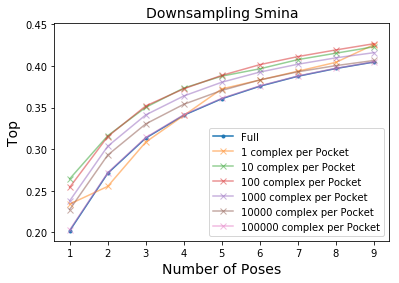

In [345]:
plt.plot([1,2,3,4,5,6,7,8,9],smina_top['good2'],label='Full',marker='.')

for key in sorted(list(smina_ds_dic.keys())):
    plt.plot(range(1,10),smina_ds_dic[key],label=str(key)+' complex per Pocket',marker='x',alpha=0.5)

plt.legend()
plt.xlabel('Number of Poses')
plt.ylabel('Top')
plt.ylim(0.19,.451)
plt.title('Downsampling Smina')
plt.savefig('downsample_smina.png', dpi=1000)

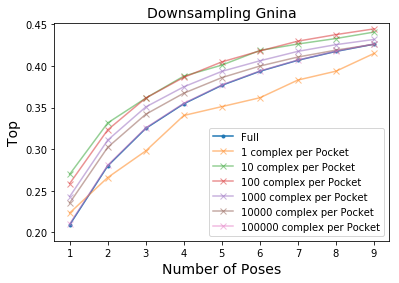

In [344]:
plt.plot([1,2,3,4,5,6,7,8,9],gnina_top['good2'],label='Full',marker='.')

for key in sorted(list(gnina_ds_dic.keys())):
    plt.plot(range(1,10),gnina_ds_dic[key],label=str(key)+' complex per Pocket',marker='x',alpha=0.5)

plt.legend()
plt.xlabel('Number of Poses')
plt.ylabel('Top')
plt.ylim(0.19,.451)
plt.title('Downsampling Gnina')
plt.savefig('downsample_gnina.png', dpi=1000)

In [334]:
pp_smina_ds_dic={}
pp_gnina_ds_dic={}
for nsamples,skeys in sorted(list(skey_dict.items())):
    sdata=[]
    gdata=[]
    for i in range(1,10):
        sdata.append(topN(i,sdatadic,2,redkeys=skeys,perpocket=True))
        gdata.append(topN(i,gdatadic,2,redkeys=skeys,perpocket=True))
    pp_smina_ds_dic[nsamples]=sdata
    pp_gnina_ds_dic[nsamples]=gdata

94
94
94
94
94
94
94
94
94
94
94
94
94
94
94
94
94
94
908
908
908
908
908
908
908
908
908
908
908
908
908
908
908
908
908
908
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
46034
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
195233
631844
631840
631844
631840
631844
631840
631844
631840
631844
631840
631844
631840
631844
631840
631844
631840
631844
631840


In [316]:
pp_smina_top=[]
pp_gnina_top=[]

for i in range(1,10):
    pp_smina_top.append(topN(i,sdatadic,2,perpocket=True))
    pp_gnina_top.append(topN(i,gdatadic,2,perpocket=True))

642410
642406
642410
642406
642410
642406
642410
642406
642410
642406
642410
642406
642410
642406
642410
642406
642410
642406


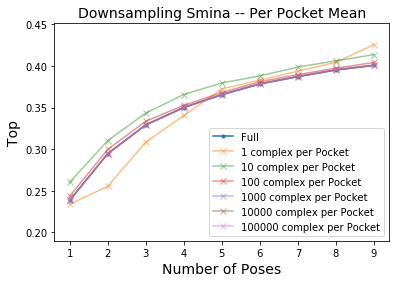

In [342]:
plt.plot([1,2,3,4,5,6,7,8,9],pp_smina_top,label='Full',marker='.')

for key in sorted(list(pp_smina_ds_dic.keys())):
    plt.plot(range(1,10),pp_smina_ds_dic[key],label=str(key)+' complex per Pocket',marker='x',alpha=0.5)

plt.legend()
plt.xlabel('Number of Poses')
plt.ylim(0.19,.451)
plt.ylabel('Top')
plt.title('Downsampling Smina -- Per Pocket Mean')
plt.savefig('downsample_smina_perpocket.png', dpi=1000)

In [351]:
for i in [1,10,100,1000,10000,100000]:
    print('----------',i,'------------')
    print(np.array(pp_smina_ds_dic[i])-np.array(pp_smina_top))

('----------', 1, '------------')
[-0.00463727 -0.03915051 -0.0205105  -0.00949517  0.00707606  0.00470321
  0.00663256  0.00925443  0.02499164]
('----------', 10, '------------')
[ 0.02160387  0.01581403  0.01424127  0.01568213  0.01416826  0.00966775
  0.0115971   0.01102748  0.0129349 ]
('----------', 100, '------------')
[ 0.00497475  0.00519205  0.00446741  0.00273151  0.00270725  0.00263714
  0.00254944  0.00225355  0.0035345 ]
('----------', 1000, '------------')
[-0.00019617  0.00029515  0.00054297  0.00064818  0.00087061  0.00076847
  0.00063114  0.00061974  0.00061312]
('----------', 10000, '------------')
[  3.78247838e-05   1.44977102e-04   1.03528961e-04   9.93885553e-05
   1.08341937e-04   1.25149182e-04   1.46876543e-04   1.20755605e-04
   1.17478194e-04]
('----------', 100000, '------------')
[  2.92841361e-07   7.57918348e-08  -5.69943590e-07   3.62170896e-06
   5.54014335e-06   4.49403476e-06   3.46609188e-06   3.89956552e-06
   3.76518925e-06]


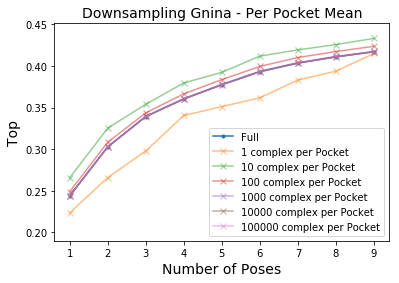

In [343]:
plt.plot([1,2,3,4,5,6,7,8,9],pp_gnina_top,label='Full',marker='.')

for key in sorted(list(pp_gnina_ds_dic.keys())):
    plt.plot(range(1,10),pp_gnina_ds_dic[key],label=str(key)+' complex per Pocket',marker='x',alpha=0.5)

plt.legend()
plt.xlabel('Number of Poses')
plt.ylim(0.19,.451)
plt.ylabel('Top')
plt.title('Downsampling Gnina - Per Pocket Mean')
plt.savefig('downsample_gnina_perpocket.png', dpi=1000)

In [352]:
for i in [1,10,100,1000,10000,100000]:
    print('----------',i,'------------')
    print(np.array(pp_gnina_ds_dic[i])-np.array(pp_gnina_top))

('----------', 1, '------------')
[-0.02051021 -0.03676015 -0.0412312  -0.01979296 -0.02620777 -0.03126377
 -0.020302   -0.01713349 -0.00202873]
('----------', 10, '------------')
[ 0.02168837  0.02245971  0.01479717  0.01921413  0.01492698  0.01873623
  0.01586821  0.01478141  0.01605638]
('----------', 100, '------------')
[ 0.00503193  0.00563841  0.00452647  0.00613949  0.00621819  0.00638573
  0.00671296  0.0064578   0.00655826]
('----------', 1000, '------------')
[ -4.32939528e-04   8.21373017e-05   4.01530980e-04   5.74748154e-04
   7.11376997e-04   7.10687690e-04   6.80056382e-04   6.77377496e-04
   4.88388724e-04]
('----------', 10000, '------------')
[  9.14430508e-05   1.45662424e-04   1.22621203e-04   1.43912238e-04
   1.16808793e-04   1.69316579e-04   1.88234086e-04   1.46040502e-04
   1.64618872e-04]
('----------', 100000, '------------')
[ -8.29093704e-07  -1.05340759e-06  -1.68173164e-06   6.73078292e-07
  -5.60414286e-07   3.10154790e-06   3.24707761e-06   4.35660264e

In [264]:
ddirs=pd.read_csv('dir_counts.txt')

In [267]:
ddirs['Complexes']=ddirs['Num_Fix_Ligs']*ddirs['Num_Recs']

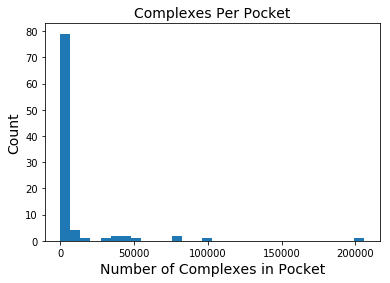

In [277]:
plt.hist(ddirs['Complexes'],bins=30)
plt.ylabel('Count')
plt.xlabel('Number of Complexes in Pocket')
plt.title('Complexes Per Pocket')
plt.savefig('complex_hist.png', dpi=1000)

In [379]:
##making reduced samples of the docking jobs.
todo=glob.glob('gnina*_cmds.txt')

In [380]:
todo

['gnina_cmds.txt', 'gnina_scoreonly_cmds.txt']

In [386]:
len(skey_dict[100])

8153

In [385]:
for item in todo:
    print(item, item.replace('gnina','gnina_ds'))
    with open(item) as infile:
        with open(item.replace('gnina','gnina_ds'),'w') as outfile:
            for line in infile:
                r=re.split(r'-r /scr/paul/',line)[1].split('_PRO')[0]
                l=re.split(r'-l /scr/paul/',line)[1].split('_LIG')[0].split('/')[-1]
                if r+':'+l in skey_dict[100]:
                    outfile.write(line)

('gnina_cmds.txt', 'gnina_ds_cmds.txt')
('gnina_scoreonly_cmds.txt', 'gnina_ds_scoreonly_cmds.txt')


In [368]:
re.split(r'-r /scr/paul/',l)[1].split('_PRO')[0]

'carlos_cd/AA2AR/PDB_Structures/3EML'

In [373]:
re.split(r'-l /scr/paul/',l)[1].split('_LIG')[0].split('/')[-1]

'3QAK'

## Analysis of the Gnina refine methods

In [12]:
#getting the keys:
tt=pd.read_csv('gnina_cd_refine_rmsds.csv')

In [13]:
red_set=set()
for r, l in zip(tt['rec'],tt['lig']):
    red_set.add((r,l))

In [14]:
len(red_set), len(tt['rec'])

(8153, 73259)

In [22]:
with open('gninadocked_rmsds.csv') as infile:
    with open('gninadocked_ds_rmsds.csv','w') as outfile:
        for i, line in enumerate(infile):
            if i==0:
                outfile.write(line)
            else:
                items=line.rstrip().split(',')
                r=items[-2]
                l=items[-1]
                if (r,l) in red_set:
                    outfile.write(line)

In [23]:
!wc gninadocked_ds_rmsds.csv

  67500   67500 5964176 gninadocked_ds_rmsds.csv


In [6]:
todo=glob.glob('*ref*csv')

In [7]:
todo=['full','gninadocked_ds_rmsds.csv']+todo

In [8]:
todo

['full',
 'gninadocked_ds_rmsds.csv',
 'gnina_gen_refine_rmsds.csv',
 'gnina_dense_refine_rmsds.csv',
 'gnina_cd_refine_rmsds.csv']

In [9]:
gdatadic=make_dict('gninadocked_rmsds.csv')

In [10]:
topN(2,gdatadic,2,perpocket=True)

642406


0.30271759219984129

In [15]:
skeys=set([x+':'+y for x,y in red_set])

In [16]:
r_gdatadic=make_dict('gninadocked_ds_rmsds.csv')

In [17]:
topN(2,r_gdatadic,2,perpocket=True)

8153


0.30835599810523823

In [18]:
#make a dic of item-> 9 values
datadic={}
for item in todo:
    data=[]
    if item=='full':
        for i in range(1,10):
            data.append(topN(i,gdatadic,2,perpocket=True))
    else:
        tmpdic=make_dict(item)
        for i in range(1,10):
            data.append(topN(i,tmpdic,2,perpocket=True))
    datadic[item]=data

642406
642406
642406
642406
642406
642406
642406
642406
642406
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153


In [19]:
todo_keys=['Full','Full_ds','Refine_Gen','Refine_Dense','Refine_CD']

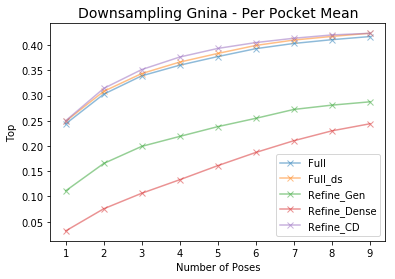

In [20]:
for key,key2 in zip(todo,todo_keys):
    plt.plot(range(1,10),datadic[key],label=str(key2),marker='x',alpha=0.5)

plt.legend()
plt.xlabel('Number of Poses')
#plt.ylim(0.19,.451)
plt.ylabel('Top')
plt.title('Downsampling Gnina - Per Pocket Mean')
plt.savefig('gnina_refinement.png', dpi=1000)

## Starting sweep over params

In [38]:
og_gninadocked=make_dict('gnina_ds_default_docked_rmsds.csv')

In [39]:
og_gninarescore=make_dict('gnina_default_rescore_docked_rmsds.csv')

In [42]:
tomake=glob.glob('gnina_*_docked_rmsds.csv')
tomake=[x for x in tomake if '_ae_' not in x]
tomake=[x for x in tomake if '_nm100_' not in x]

In [44]:
og_data={
    'aba':'4',
    'minsf':'False',
    'minrmsdf':'1.0',
    'ex':'8'
}

In [45]:
gdatadic={} #dictionary analysis->key->[list of topN]
rdatadic={} #same format dictionary, but for rescored
for item in ['aba','minsf','minrmsdf','ex']:
    #setting up the rest of the dictionary
    gdatadic[item]={}
    rdatadic[item]={}
    
    #setting the appropriate value for the original data
    ogkey=og_data[item]
    gdatadic[item][ogkey]=[]
    rdatadic[item][ogkey]=[]
    
    #filling with the data
    for seed in range(1,10):
        val=topN(seed,og_gninadocked,2,perpocket=True)
        gdatadic[item][ogkey].append(val)
        
        val2=topN(seed,og_gninarescore,2,perpocket=True)
        rdatadic[item][ogkey].append(val2)
    
    #now we need to repeat this proess for the rest of the csv files.
    grand_todo=[x for x in tomake if item in x]
    
    #first we will work on the OG docking data
    todo=[x for x in grand_todo if '_rescore_' not in x]
    for fname in todo:
        tempdic=make_dict(fname)
        if item=='minsf':
            key='True'
        else:
            key=fname.split(item)[1].split('_')[0]
        #we have the key and need to make the list
        gdatadic[item][key]=[]
        
        for seed in range(1,10):
            val=topN(seed,tempdic,2,perpocket=True)
            gdatadic[item][key].append(val)
    
    #now we will work on the CNN rescore docking data
    r_todo=[x for x in grand_todo if '_rescore_' in x]
    for fname in r_todo:
        tempdic=make_dict(fname)
        if item=='minsf':
            key='True'
        else:
            key=fname.split(item)[1].split('_')[0]
        #we have the key and need to make the list
        rdatadic[item][key]=[]
        
        for seed in range(1,10):
            val=topN(seed,tempdic,2,perpocket=True)
            rdatadic[item][key].append(val)

8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8152
8152
8152
8152
8152
8152
8152
8152
8152
8125
8125
8125
8125
8125
8125
8125
8125
8125
8125
8125
8125
8125
8125
8125
8125
8125
8125
8152
8152
8152
8152
8152
8152
8152
8152
8152
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153


In [46]:
titles={
    'aba':'--autobox_add',
    'minrmsdf':'--min_rmsd_filter',
    'ex':'--exhaustiveness',
    'minsf':'--minimize_single_full'
}

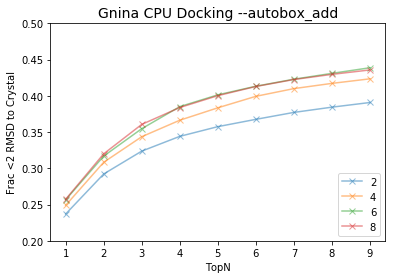

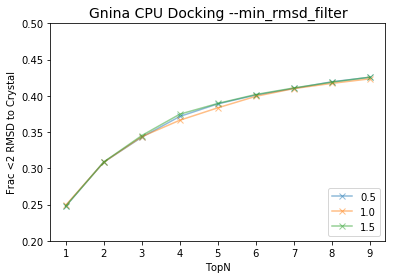

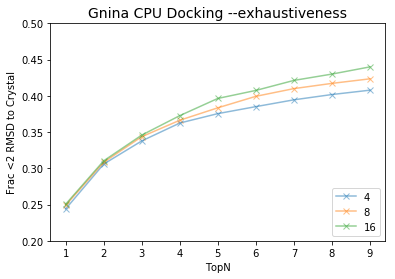

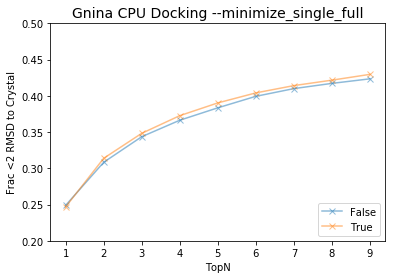

In [47]:
for key1 in gdatadic.keys():
    tmp=[]
    for key2 in gdatadic[key1].keys():
        tmp.append(key2)
    
    if key1 == 'ex':
        tmp=sorted(tmp,key=lambda x: int(x))
    else:
        tmp=sorted(tmp)
    fig=plt.figure()
    for key2 in tmp:
        plt.plot(range(1,10),gdatadic[key1][key2],label=str(key2),marker='x',alpha=0.5)
    plt.legend(loc='lower right')
    plt.xlabel('TopN')
    plt.ylabel('Frac <2 RMSD to Crystal')
    plt.title('Gnina CPU Docking '+titles[key1])
    plt.ylim((0.20,0.50))
    plt.savefig('gnina_cpu_sweep_'+key1+'.png',dpi=1000)

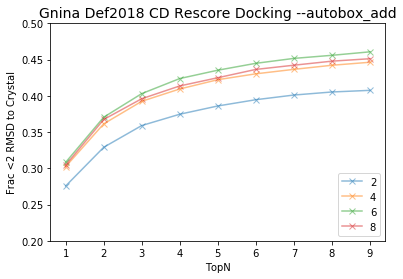

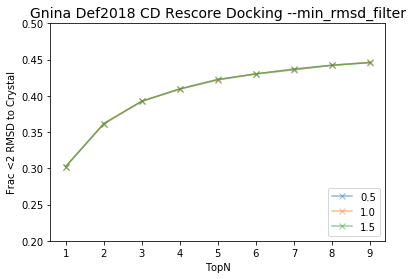

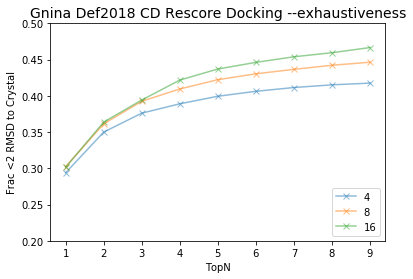

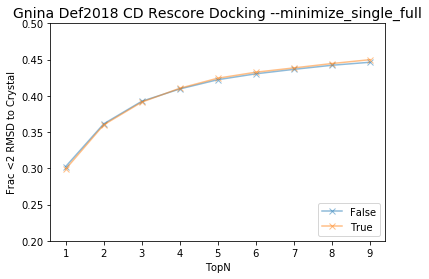

In [48]:
for key1 in rdatadic.keys():
    tmp=[]
    for key2 in rdatadic[key1].keys():
        tmp.append(key2)
    
    if key1 == 'ex':
        tmp=sorted(tmp,key=lambda x: int(x))
    else:
        tmp=sorted(tmp)
    fig=plt.figure()
    for key2 in tmp:
        plt.plot(range(1,10),rdatadic[key1][key2],label=str(key2),marker='x',alpha=0.5)
    plt.legend(loc='lower right')
    plt.xlabel('TopN')
    plt.ylabel('Frac <2 RMSD to Crystal')
    plt.title('Gnina Def2018 CD Rescore Docking '+titles[key1])
    plt.ylim((0.20,0.50))
    plt.savefig('gnina_CNNrescore_cpu_sweep_'+key1+'.png',dpi=1000)

## New plots with nm100 for exhaustiveness and aba--extend

In [49]:
gdatadic={} #dictionary analysis->key->[list of topN]
rdatadic={} #same format dictionary, but for rescored
for item in ['ae','nm100']:
    #setting up the rest of the dictionary
    gdatadic[item]={}
    rdatadic[item]={}
    
    #now we need to repeat this proess for the rest of the csv files.
    grand_todo=glob.glob('*'+item+'*rmsds.csv')
    
    #first we will work on the OG docking data
    todo=[x for x in grand_todo if '_rescore_' not in x]
    for fname in todo:
        tempdic=make_dict(fname)
        key=fname.split('_')[1]
        if key=='defaults':
            key='ex8'
        #we have the key and need to make the list
        gdatadic[item][key]=[]
        
        for seed in range(1,10):
            val=topN(seed,tempdic,2,perpocket=True)
            gdatadic[item][key].append(val)
    
    #now we will work on the CNN rescore docking data
    r_todo=[x for x in grand_todo if '_rescore_' in x]
    for fname in r_todo:
        tempdic=make_dict(fname)
        key=fname.split('_')[1]
        if key=='defaults':
            key='ex8'
        #we have the key and need to make the list
        rdatadic[item][key]=[]
        
        for seed in range(1,10):
            val=topN(seed,tempdic,2,perpocket=True)
            rdatadic[item][key].append(val)

8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8152
8152
8152
8152
8152
8152
8152
8152
8152
8152
8152
8152
8152
8152
8152
8152
8152
8152
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153


In [50]:
titles={
    'ae':'--autobox_add  --autobox_extend',
    'nm100':'--exhaustiveness  --num_modes 100'
}

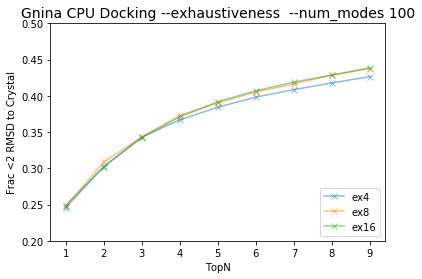

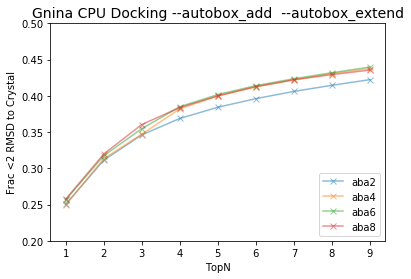

In [53]:
for key1 in gdatadic.keys():
    tmp=[]
    for key2 in gdatadic[key1].keys():
        tmp.append(key2)
    
    if key1 == 'nm100':
        tmp=sorted(tmp,key=lambda x: int(x[2:]))
    else:
        tmp=sorted(tmp)
    fig=plt.figure()
    for key2 in tmp:
        plt.plot(range(1,10),gdatadic[key1][key2],label=str(key2),marker='x',alpha=0.5)
    plt.legend(loc='lower right')
    plt.xlabel('TopN')
    plt.ylabel('Frac <2 RMSD to Crystal')
    plt.title('Gnina CPU Docking '+titles[key1])
    plt.ylim((0.20,0.50))
    plt.savefig('gnina_cpu_sweep_'+key1+'.png',dpi=1000)

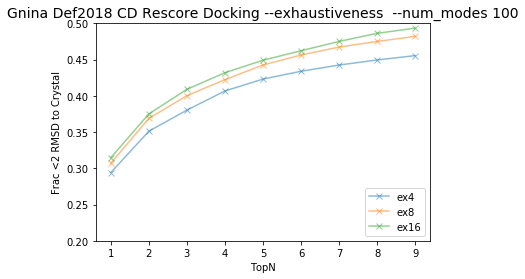

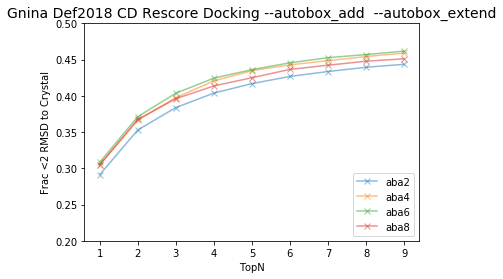

In [54]:
for key1 in rdatadic.keys():
    tmp=[]
    for key2 in rdatadic[key1].keys():
        tmp.append(key2)
    
    if key1 == 'nm100':
        tmp=sorted(tmp,key=lambda x: int(x[2:]))
    else:
        tmp=sorted(tmp)
    fig=plt.figure()
    for key2 in tmp:
        plt.plot(range(1,10),rdatadic[key1][key2],label=str(key2),marker='x',alpha=0.5)
    plt.legend(loc='lower right')
    plt.xlabel('TopN')
    plt.ylabel('Frac <2 RMSD to Crystal')
    plt.title('Gnina Def2018 CD Rescore Docking '+titles[key1])
    plt.ylim((0.20,0.50))
    plt.savefig('gnina_CNNrescore_cpu_sweep_'+key1+'.png',dpi=1000)

## Doing the single model rescoring vs ensembles

In [19]:
single_model={}#dic of <model name> -> topN
ensemble_model={}#dic of <model name> -> topN

In [20]:
todo=glob.glob('*_defaults.csv')

In [21]:
#dealing with single models
for fname in [x for x in todo if 'ensemble' not in x]:
    if '_gen_' in fname:
        key='Gen Def2018'
    elif '_def2017' in fname:
        key='Def2017'
    elif '_cd_def2018' in fname:
        key='CD2020 Def2018'
    elif '_dense_' in fname:
        key='CD2020 Dense'
    else:
        key='Vina'
    
    tmp=make_dict(fname)
    single_model[key]=[]
    for seed in range(1,10):
        val=topN(seed,tmp,2,perpocket=True)
        single_model[key].append(val)

8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153


In [22]:
#doing the same but for the ensemble models
#dealing with single models
for fname in [x for x in todo if 'ensemble' in x]:
    if '_gen_' in fname:
        key='Gen Def2018'
    elif '_def2017' in fname:
        key='Def2017'
    elif '_cd_def2018' in fname:
        key='CD2020 Def2018'
    elif '_dense_' in fname:
        key='CD2020 Dense'
    else:
        key='All models'
    
    tmp=make_dict(fname)
    ensemble_model[key]=[]
    for seed in range(1,10):
        val=topN(seed,tmp,2,perpocket=True)
        ensemble_model[key].append(val)

8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153
8153


In [23]:
single_model.keys()

['Vina', 'Def2017', 'CD2020 Def2018', 'CD2020 Dense', 'Gen Def2018']

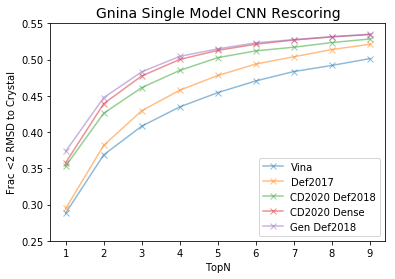

In [33]:
fig=plt.figure()
for key in single_model.keys():
    plt.plot(range(1,10),single_model[key],label=str(key),marker='x',alpha=0.5)
    plt.legend(loc='lower right')
    plt.xlabel('TopN')
    plt.ylabel('Frac <2 RMSD to Crystal')
    plt.title('Gnina Single Model CNN Rescoring')
    plt.ylim((0.25,0.55))
    plt.savefig('gnina_CNNrescore_defaults.png',dpi=1000)

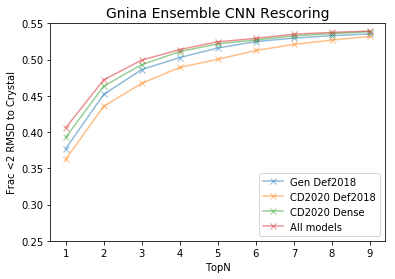

In [32]:
fig=plt.figure()
for key in ensemble_model.keys():
    plt.plot(range(1,10),ensemble_model[key],label=str(key),marker='x',alpha=0.5)
    plt.legend(loc='lower right')
    plt.xlabel('TopN')
    plt.ylabel('Frac <2 RMSD to Crystal')
    plt.title('Gnina Ensemble CNN Rescoring')
    plt.ylim((0.25,0.55))
    plt.savefig('gnina_ensemble_CNNrescore_defaults.png',dpi=1000)